In [1]:
import numpy as np
from numpy import *
from numpy import random
from numpy import linalg as LA
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import networkx as nx
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from matplotlib.cm import get_cmap
from tqdm import tqdm

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

# After np version 19 ragged np arrays lead to a VisibleDeprecationWarning, which can be turned off: 


In [2]:
def create_custom_colormap():
    """
    Create a custom colormap where zero is black and positive integers follow the tab20 colormap.
    
    Returns:
    custom_cmap (ListedColormap): The custom colormap for the image.
    """
    # Create a base colormap from tab20
    base_cmap = plt.cm.get_cmap('tab20', 20)

    # Create a list of colors where the first color is black (for zero elements)
    # and the rest are from the tab20 colormap
    colors = [(0, 0, 0, 1)] + [base_cmap(i) for i in range(base_cmap.N)]
    
    # Create a custom colormap
    custom_cmap = ListedColormap(colors)

    return custom_cmap


def create_custom_colormap():
    """
    Create a custom colormap where zero is black and positive integers follow the tab20 colormap.

    Returns:
    custom_cmap (ListedColormap): The custom colormap for the image.
    """
    # Create a base colormap from tab20
    base_cmap = plt.colormaps['tab20']

    # Create a list of colors where the first color is black (for zero elements)
    # and the rest are from the tab20 colormap
    colors = [(0, 0, 0, 1)] + [base_cmap(i) for i in range(base_cmap.N)]

    # Create a custom colormap
    custom_cmap = ListedColormap(colors)

    return custom_cmap

In [3]:
# Load all data into one list, the list is not partitioned: the first i entries correspond to the first fc value, 
# ..then after every period of length i a new fc value is assigned, resulting in total of j periods of length i


def getNetwork(i_network, plot=True):
    nsim=100
    baseAddress="/home/alifeleparanj/Projects/MathMaster/Data/UcarPaper/"
    
    coordinates_all = []
    for j in arange(0.4,1.6,0.1):
        for i in range(nsim):
            coordinates_all.append(np.load(baseAddress+'Simulations/axial_data/fcbias_parallel_pb003_fa0_fc'+str(round(j,1)).replace('.','')+'_coord_v'+str(int(i))+'.npy'))
            
    angles_all = []
    for j in arange(0.4,1.6,0.1):
        for i in range(nsim):
            angles_all.append(np.load(baseAddress+'Simulations/axial_data/fcbias_parallel_pb003_fa0_fc'+str(round(j,1)).replace('.','')+'_angles_v'+str(int(i))+'.npy'))

    network = coordinates_all[i_network]
    angleList = angles_all[i_network]
    return turnCoordinateIntoMatrix(network,plot=plot), network, angleList

def loadExperimentalData(i_network, plot=True):
    baseAddress="/home/alifeleparanj/Projects/MathMaster/Data/UcarPaper/"
    v = i_network%8
    names=['f1','f2','f3','f4','A5','A7','A8f1','A8f2']
    sample_name = names[v]
    
    # Load coordinate and local angle values from saved data
    coordinates=np.load(baseAddress+'Experiment/expdata_'+sample_name+'_coordinates_rescaled.npy')
    angle_list=np.load(baseAddress+'Experiment/expdata_'+sample_name+'_localangle_rescaled.npy')
    
    # The estimated coordinates for the origin of the network
    origin = np.load(baseAddress+'Experiment/expdata_'+sample_name+'_origin_coordinates_left.npy')
    # location of the origin coordinate within the array "coordinates":
    orig_pos = np.argmin(LA.norm(np.add(origin[:2],-coordinates[:,:2]),axis=1))

    return turnCoordinateIntoMatrix(coordinates,plot=True)


cmap = get_cmap('tab10',int(100))
colorList = [cmap(i) for i in range(int(100))]
def turnCoordinateIntoMatrix(network,plot=True):
    lenList = []
    max_x = int(np.ceil(np.max(network[:, 0])))
    max_y = int(np.ceil(np.max(network[:, 1])))
    min_x = int(np.ceil(np.min(network[:, 0])))
    min_y = int(np.ceil(np.min(network[:, 1])))
    margin = 20
    vascular_matrix = np.zeros((max_y-min_y+margin, max_x -min_x+margin), dtype=np.int32)
    for i in range(1,int(network[-1,-1])):
        segment = network[network[:,-1]==i]
        if plot == True and len(segment)>0:
            color=colorList[int(segment[0,2])]
            plt.plot(segment[:,0],(max_y-min_y)-segment[:,1],lw=2,c=color,solid_capstyle='round',solid_joinstyle='round')
            plt.axis("off")
            plt.grid(False)
            
        lenList.append(segment.shape[0])
        for x, y, parent,selfID in segment[:, :4]:
            vascular_matrix[int(y-min_y+margin/2), int(x-min_x+margin/2)] = (1)+selfID
    
    return vascular_matrix




def enhance_for_loops(A,kernelSize):
    # Assuming binary_matrix is your binary image (numpy array)
    # For demonstration, let's create a random binary matrix
    binary_matrix = A.astype(np.uint8) * 255  # Convert to 8-bit format with 0 and 255
    

    # Define a kernel for dilation (structuring element)
    kernel_size = kernelSize  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply dilation
    dilated_image = cv2.dilate(binary_matrix, kernel, iterations=1)
    
    kernel_size = kernel_size-1  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    # kernel_size = 1 # You can adjust this size
    # kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # final_image = cv2.dilate(eroded_image, kernel, iterations=1)
    final_image = eroded_image.copy()
    return final_image    
    
    
    # # Display the original and dilated images
    # plt.figure(figsize=(10, 10))
    
    # plt.subplot(1, 3, 1)
    # plt.title('Original Binary Image')
    # plt.imshow(binary_matrix, cmap='gray')
    
    # plt.subplot(1, 3, 2)
    # plt.title('Dilated Image')
    # plt.imshow(dilated_image, cmap='gray')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Eroded Image')
    # plt.imshow(eroded_image, cmap='gray')
    
    # plt.show()


/tmp/ipykernel_10922/2620693007.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10',int(100))


In [4]:


def map_to_square(arr,dest):
    # Find the minimum and maximum values for each column (x and y coordinates)
    min_vals = arr.min(axis=0)
    max_vals = arr.max(axis=0)
    
    # Normalize the coordinates to [0, 1]
    norm_arr = (arr - min_vals) / (max_vals - min_vals)
    
    # Scale and shift to [-1, 1]
    shift = dest -np.array([1,0])
    scaled_arr = norm_arr * 2 +shift
    
    return scaled_arr


# Step 1: Skeletonize the Image
def skeletonize_image(binary_image):
    return skeletonize(binary_image // 255).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    # Use a connectivity-8 kernel to find nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))

# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return G

# Step 4: Find Cycles
def find_cycles(graph):
    cycles = list(nx.cycle_basis(graph))
    return cycles




# Optional: Visualize the results
def visualize_cycles(image, cycles):
    plt.imshow(image, cmap='gray')
    for cycle in cycles:
        cycle = np.array(cycle)
        plt.plot(cycle[:, 0], cycle[:, 1], 'r-')
    # plt.axis("off")
    # plt.grid(False)
    # plt.savefig("BARWProc2.png", bbox_inches='tight')



def detectLoops(final_image, plot=True):
    
    # final_image = final_image.astype(np.uint8) * 255
    binary_image = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)[1]
    
    skeleton = skeletonize_image(binary_image)
    nodes = detect_nodes_edges(skeleton)
    graph = create_graph(skeleton, nodes)
    cycles_unfiltered = find_cycles(graph)
    
    cycles = [sublist for sublist in cycles_unfiltered if len(sublist) >= 5]
    for cycle in cycles:
        cycle.append(cycle[0])
    
    print(f"Detected {len(cycles)} cycles in the image.")

    if plot == True:
        visualize_cycles(skeleton, cycles)
    
    return skeleton, cycles, graph


def map_to_square(arr,dest):
    # Find the minimum and maximum values for each column (x and y coordinates)
    min_vals = arr.min(axis=0)
    max_vals = arr.max(axis=0)
    
    # Normalize the coordinates to [0, 1]
    norm_arr = (arr - min_vals) / (max_vals - min_vals)
    
    # Scale and shift to [-1, 1]
    shift = dest -np.array([1,0])
    scaled_arr = norm_arr * 2 +shift
    
    return scaled_arr

In [6]:
network, _, _ = getNetwork(5,plot=False)
# plt.gca().set_facecolor('#212121')
# network = loadExperimentalData(1)
network = enhance_for_loops(network,3) ## Change the value of kernel size to filter different loop sizes


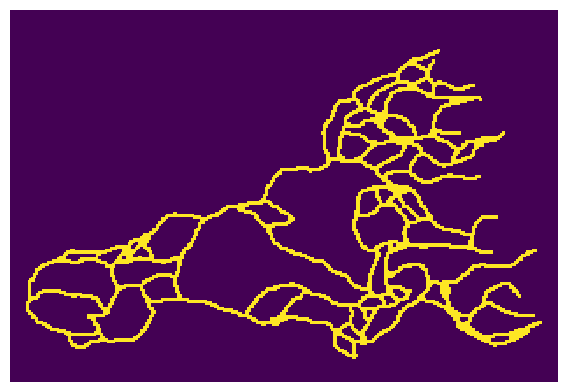

In [7]:
network_ = network.copy()
network_[network>0]= 1
plt.matshow(network_)
plt.axis("off")
plt.grid(False)
plt.savefig("BARWProc1.png", bbox_inches="tight")

In [8]:
network[network>0]

array([137, 137, 137, ..., 212, 216, 216], dtype=uint8)

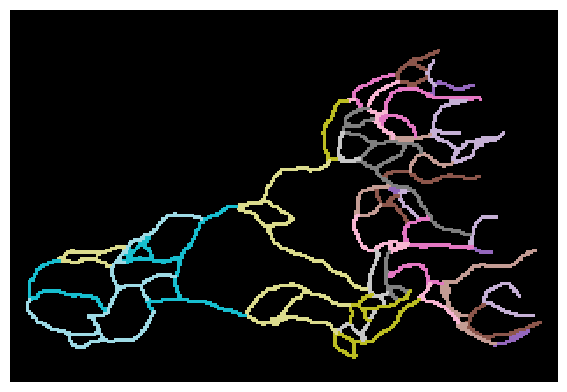

In [9]:
plt.matshow(network,cmap=create_custom_colormap())
plt.axis("off")
plt.grid(False)

Detected 44 cycles in the image.


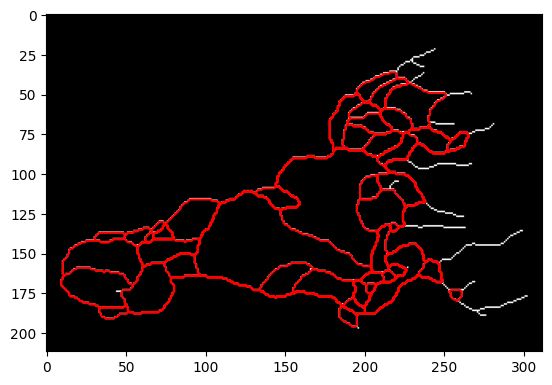

In [10]:
skeleton, cycles, graph = detectLoops(network)

Text(0, 0.5, 'Count')

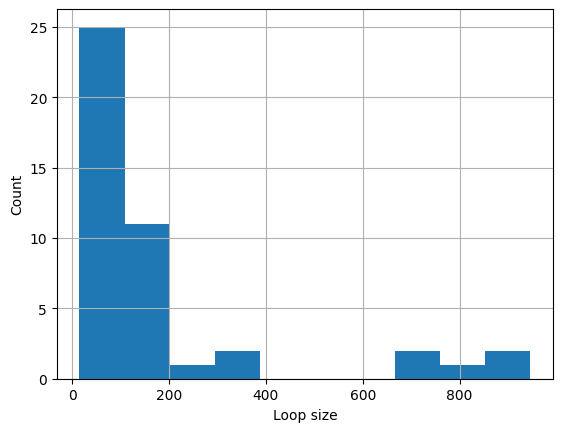

In [11]:
lenList = [len(cycle) for cycle in cycles]
_ = plt.hist(lenList)
plt.grid()
plt.xlabel("Loop size")
plt.ylabel("Count")

IndexError: list index out of range

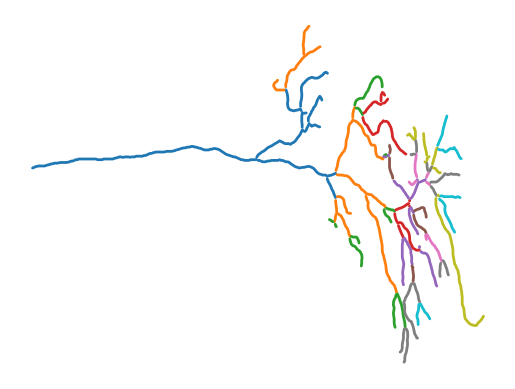

In [12]:
network = loadExperimentalData(4)


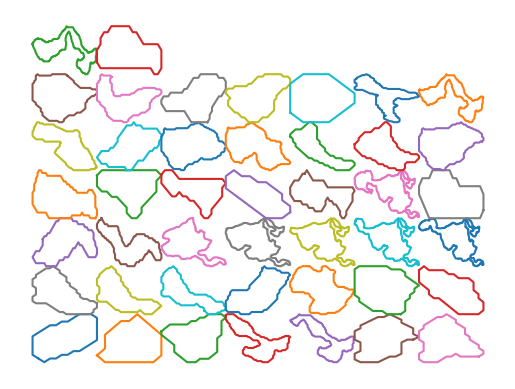

In [13]:
L = int(len(cycles)**(1/2)+1)//2
xList = np.arange(-2*L,2*(L+1),2)
X,Y = np.meshgrid(xList,xList)

i=0
for x,y in zip(X.ravel(),Y.ravel()):
    if (i < len(cycles)):
        arr = map_to_square(np.array(cycles[i]),np.array([x,y]))
        plt.plot(arr[:,0],arr[:,1])
    i+=1


# plt.title("Scaled Extracted Loops")
plt.axis("off")
plt.savefig("loopsBARW.png",bbox_inches="tight")

In [14]:
nsim=100
i_network = 4
baseAddress="/home/alifeleparanj/Projects/MathMaster/Data/UcarPaper/"

coordinates_all = []
for j in arange(0.4,1.6,0.1):
    for i in range(nsim):
        coordinates_all.append(np.load(baseAddress+'Simulations/axial_data/fcbias_parallel_pb003_fa0_fc'+str(round(j,1)).replace('.','')+'_coord_v'+str(int(i))+'.npy'))

angles_all = []
for j in arange(0.4,1.6,0.1):
    for i in range(nsim):
        angles_all.append(np.load(baseAddress+'Simulations/axial_data/fcbias_parallel_pb003_fa0_fc'+str(round(j,1)).replace('.','')+'_angles_v'+str(int(i))+'.npy'))

network = coordinates_all[i_network]

Text(0, 0.5, 'Count')

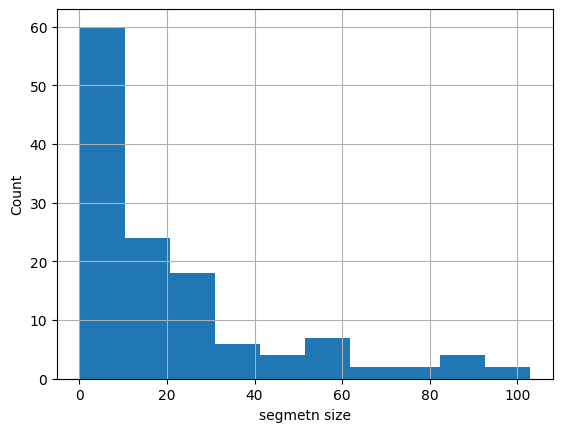

In [15]:
lenList = [len(network[network[:,-1]==i]) for i in range(1,int(np.max(network[:,-1])))]
_ = plt.hist(lenList)
plt.grid()
plt.xlabel("segmetn size")
plt.ylabel("Count")

## Experimenting with Turning Networks to Graphs

Some errors of the algorithm of turning the resulting network into a graph:

1) At the anhillation points the end points do not break the edges into two seperate pieces before and after the anhillation points
2) Some of the nodes as the initial position are super close to each other. We can merge these nodes into a same node

In [579]:
_, network, angleList = getNetwork(30,False)

In [580]:
sproutDict = dict()  ## contains the [x,y] position of each branch. The key is branchID
angleDict = dict()  ## contains the angle of each point of each branch. The key is branchID
R = 0 ## The extension length
L_cut = 4 ## the sprouts shorter than this length will be removed
for i in range(1,int(network[-1,-1])):
    coords = network[network[:,-1]==i]
    angles = angleList[angleList[:,1]==i]
    if angles.shape[0] > L_cut:
        # extension
        tipAngle = np.deg2rad(angles[-1,0])
        dx = R * np.cos(tipAngle)
        dy = R * np.sin(tipAngle)
        newPos = coords[-1,:] + np.array([dx,dy,0,0])
        coords = np.vstack([coords,newPos]) ## These two numbers (-1) will not be recorded in the final dictionary
        
        sproutDict[i] = coords[:,:2]
        angleDict[i] = np.deg2rad(angles[:,0])


# ## extending each branch end according to the end angle
# R = 1
# for ID in sproutDict.keys():
#     sproutPosList = sproutDict[ID]
#     angleList = angleDict[ID]
#     dx = R * np.cos(angleList[-1])
#     dy = R * np.sin(angleList[-1])
#     newPos = sproutPosList[-1,:] + np.array([dx,dy])
#     sproutDict[ID] = np.vstack([sproutPosList, newPos])

    

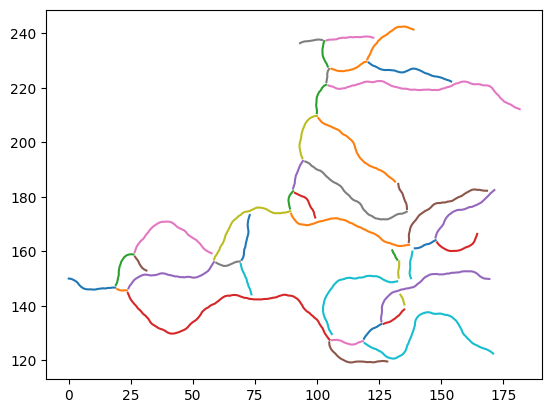

In [581]:
for branchID in sproutDict.keys():
    coord = sproutDict[branchID]
    plt.plot(coord[:,0],coord[:,1])

In [582]:
for sprout_id, coords in sproutDict.items():
    # Start node
    start_point = tuple(coords[0])


In [583]:
# import numpy as np
# import networkx as nx
# from scipy.spatial import KDTree
# def find_closest_point_on_curve(curve, point):
#     """Find the closest point on a curve to a given point."""
#     distances = np.linalg.norm(curve - point, axis=1)
#     closest_idx = np.argmin(distances)
#     return closest_idx

# def merge_close_nodes(G, proximity_threshold=1e-2):
#     """Merge nodes that are within the proximity_threshold distance."""
#     nodes = list(G.nodes)
#     kdtree = KDTree(nodes)
    
#     # Track merged nodes
#     merged_nodes = {}
    
#     for i, node in enumerate(nodes):
#         # Find neighbors within the proximity threshold
#         distances, indices = kdtree.query(node, k=2, distance_upper_bound=proximity_threshold)
#         for j in indices:
#             if j != i and j < len(nodes):
#                 close_node = nodes[j]
                
#                 # Merge node with close_node
#                 merged_node = tuple((np.array(node) + np.array(close_node)) / 2)  # Average position
                
#                 # Relabel the graph to merge nodes
#                 if close_node not in merged_nodes and node not in merged_nodes:
#                     # Relabel all edges from node and close_node to merged_node
#                     G = nx.relabel_nodes(G, {node: merged_node, close_node: merged_node})
#                     merged_nodes[node] = merged_node
#                     merged_nodes[close_node] = merged_node
                    
#     return G

# def create_graph_from_sprout_dict(sproutDict, distance_threshold=1e-2, proximity_threshold=0.5):
#     G = nx.Graph()

#     # Store all curve end points for checking close proximity
#     endpoints = []
#     endpoint_to_sprout = {}  # Mapping endpoints to the corresponding sprout IDs
    
#     for sprout_id, coords in sproutDict.items():
#         # Start node
#         start_point = tuple(coords[0])
#         G.add_node(start_point, sprout_id=sprout_id)

#         # End point
#         end_point = tuple(coords[-1])
#         endpoints.append(end_point)
#         endpoint_to_sprout[end_point] = sprout_id
        
#         # Add edge between start and end point
#         G.add_edge(start_point, end_point, curve=coords)

#     # Build KDTree to find nearest neighbors (efficient way to check closeness of points)
#     kdtree = KDTree(endpoints)
    
#     # Check if any end point is close to another curve
#     for i, end_point in enumerate(endpoints):
#         # Find neighbors within the distance threshold
#         distances, indices = kdtree.query(end_point, k=2, distance_upper_bound=distance_threshold)
#         for j in indices:
#             if j != i and j < len(endpoints):
#                 # There is an annihilation (close proximity to another curve)
#                 close_point = endpoints[j]
#                 close_sprout_id = endpoint_to_sprout[close_point]
#                 close_curve = sproutDict[close_sprout_id]
                
#                 # Find closest point on the close_curve to the end_point
#                 closest_idx = find_closest_point_on_curve(close_curve, np.array(end_point))
#                 annihilation_point = tuple(close_curve[closest_idx])
                
#                 # Split the close_curve into two parts at the annihilation point
#                 part1 = close_curve[:closest_idx + 1]
#                 part2 = close_curve[closest_idx:]

#                 # Remove the original curve's edge and replace with two new edges
#                 start_point_close = tuple(close_curve[0])
#                 end_point_close = tuple(close_curve[-1])
#                 if G.has_edge(start_point_close, end_point_close):
#                     G.remove_edge(start_point_close, end_point_close)
                
#                 G.add_node(annihilation_point)  # Add annihilation point as a new node
#                 G.add_edge(start_point_close, annihilation_point, curve=part1)  # First part
#                 G.add_edge(annihilation_point, end_point_close, curve=part2)  # Second part
                
#                 # Now add edge between end_point and annihilation_point
#                 G.add_edge(end_point, annihilation_point)  # Connect the two curves

#     # Merge nodes that are too close to each other
#     G = merge_close_nodes(G, proximity_threshold)
    
#     return G

# graph = create_graph_from_sprout_dict(sproutDict)


In [584]:

def find_closest_point_on_curve(curve, point):
    """Find the closest point on a curve to a given point."""
    distances = np.linalg.norm(curve - point, axis=1)
    closest_idx = np.argmin(distances)
    return closest_idx

def merge_close_nodes(G, proximity_threshold=5):
    """Merge nodes that are within the proximity_threshold distance."""
    nodes = list(G.nodes)
    kdtree = KDTree(nodes)

    # Keep track of which nodes have already been merged
    merged_nodes = {}
    
    # Go through each node and check all nearby nodes within the threshold
    for i, node in enumerate(nodes):
        if node in merged_nodes:
            continue
        
        # Find all neighbors within the proximity threshold
        distances, indices = kdtree.query(node, k=len(nodes), distance_upper_bound=proximity_threshold)
        merge_candidates = [nodes[j] for j in indices if j != i and j < len(nodes) and nodes[j] not in merged_nodes]

        if merge_candidates:
            # Merge all candidates and the current node into a single new node
            all_nodes_to_merge = [node] + merge_candidates
            merged_node = tuple(np.mean(all_nodes_to_merge, axis=0))  # Calculate the average position
            
            # Relabel all nodes in the graph with the merged node
            mapping = {n: merged_node for n in all_nodes_to_merge}
            G = nx.relabel_nodes(G, mapping)
            
            # Mark these nodes as merged
            for n in all_nodes_to_merge:
                merged_nodes[n] = merged_node
    
    return G

def remove_arcs_and_isolated_components(G):
    """Remove self-loops (arcs) and keep only the largest connected component."""
    # Remove self-loops (arcs)
    G.remove_edges_from(nx.selfloop_edges(G))

    # Get the largest connected component
    if nx.is_connected(G):
        return G  # Return G directly if already connected
    
    # Find all connected components and keep the largest one
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()
    
    return G_largest

def create_graph_from_sprout_dict(sproutDict, distance_threshold=2, proximity_threshold=5):
    G = nx.Graph()

    # Store all points (not just endpoints) for checking proximity
    all_points = []
    point_to_sprout = {}  # Mapping points to the corresponding sprout IDs
    sprout_points_dict = {}  # Store all points of each sprout

    for sprout_id, coords in sproutDict.items():
        # Add all points of this sprout to the global list and keep track
        sprout_points_dict[sprout_id] = coords
        for point in coords:
            all_points.append(point)
            point_to_sprout[tuple(point)] = sprout_id

    # Build KDTree for all points (not just endpoints)
    kdtree = KDTree(all_points)

    # Process each sprout
    for sprout_id, coords in sproutDict.items():
        start_point = tuple(coords[0])
        end_point = tuple(coords[-1])
        G.add_node(start_point, sprout_id=sprout_id)
        G.add_node(end_point, sprout_id=sprout_id)
        G.add_edge(start_point, end_point, curve=coords)

        # Check if the end point is close to another curve
        distances, indices = kdtree.query(end_point, k=len(all_points), distance_upper_bound=distance_threshold)

        for idx in indices:
            if idx >= len(all_points):
                break  # Stop if all close points are checked

            close_point = all_points[idx]
            close_sprout_id = point_to_sprout[tuple(close_point)]

            if close_sprout_id != sprout_id:  # Ensure it's a different sprout
                close_curve = sprout_points_dict[close_sprout_id]
                
                # Find the closest point on this curve to the current end point
                closest_idx = find_closest_point_on_curve(close_curve, np.array(end_point))

                # The annihilation point is now exactly the same as the end point
                annihilation_point = tuple(end_point)

                # Split the close_curve into two parts at the annihilation point
                part1 = close_curve[:closest_idx + 1]  # First part of the curve up to the closest point
                part2 = close_curve[closest_idx:]      # Second part of the curve after the closest point

                # Check if the original edge exists before trying to remove it
                start_node = tuple(close_curve[0])
                end_node = tuple(close_curve[-1])
                if G.has_edge(start_node, end_node):
                    G.remove_edge(start_node, end_node)
                
                G.add_node(annihilation_point, sprout_id=close_sprout_id)
                
                # Add the split edges using the annihilation point as the connecting point
                G.add_edge(start_node, annihilation_point, curve=part1)  # First part
                G.add_edge(annihilation_point, end_node, curve=part2)  # Second part

                break  # We have found the closest curve, so stop further searching

    # Merge nodes that are too close to each other (e.g., branching points and child sprouts)
    G = merge_close_nodes(G, proximity_threshold)
    
    # Remove self-loops (arcs) and keep only the largest connected component
    G = remove_arcs_and_isolated_components(G)
    
    return G

In [585]:

# def find_closest_point_on_curve(curve, point):
#     """Find the closest point on a curve to a given point."""
#     distances = np.linalg.norm(curve - point, axis=1)
#     closest_idx = np.argmin(distances)
#     return closest_idx

# def merge_close_nodes(G, proximity_threshold=5):
#     """Merge nodes that are within the proximity_threshold distance."""
#     nodes = list(G.nodes)
#     kdtree = KDTree(nodes)

#     # Keep track of which nodes have already been merged
#     merged_nodes = {}
    
#     # Go through each node and check all nearby nodes within the threshold
#     for i, node in enumerate(nodes):
#         if node in merged_nodes:
#             continue
        
#         # Find all neighbors within the proximity threshold
#         distances, indices = kdtree.query(node, k=len(nodes), distance_upper_bound=proximity_threshold)
#         merge_candidates = [nodes[j] for j in indices if j != i and j < len(nodes) and nodes[j] not in merged_nodes]

#         if merge_candidates:
#             # Merge all candidates and the current node into a single new node
#             all_nodes_to_merge = [node] + merge_candidates
#             merged_node = tuple(np.mean(all_nodes_to_merge, axis=0))  # Calculate the average position
            
#             # Relabel all nodes in the graph with the merged node
#             mapping = {n: merged_node for n in all_nodes_to_merge}
#             G = nx.relabel_nodes(G, mapping, copy=False)  # Update node names in-place
            
#             # Mark these nodes as merged
#             for n in all_nodes_to_merge:
#                 merged_nodes[n] = merged_node
    
#     return G

# def remove_arcs_and_isolated_components(G):
#     """Remove self-loops (arcs) and keep only the largest connected component."""
#     # Remove self-loops (arcs)
#     G.remove_edges_from(nx.selfloop_edges(G))

#     # Get the largest connected component
#     if nx.is_connected(G):
#         return G  # Return G directly if already connected
    
#     # Find all connected components and keep the largest one
#     largest_cc = max(nx.connected_components(G), key=len)
#     G_largest = G.subgraph(largest_cc).copy()
    
#     return G_largest

# def create_graph_from_sprout_dict(sproutDict, distance_threshold=5, proximity_threshold=5):
#     G = nx.Graph()

#     # Store all points (not just endpoints) for checking proximity
#     all_points = []
#     point_to_sprout = {}  # Mapping points to the corresponding sprout IDs
#     sprout_points_dict = {}  # Store all points of each sprout

#     for sprout_id, coords in sproutDict.items():
#         # Add all points of this sprout to the global list and keep track
#         sprout_points_dict[sprout_id] = coords
#         for point in coords:
#             all_points.append(point)
#             point_to_sprout[tuple(point)] = sprout_id

#     # Build KDTree for all points (not just endpoints)
#     kdtree = KDTree(all_points)

#     # Process each sprout
#     for sprout_id, coords in sproutDict.items():
#         start_point = tuple(coords[0])
#         end_point = tuple(coords[-1])
#         G.add_node(start_point, sprout_id=sprout_id)
#         G.add_node(end_point, sprout_id=sprout_id)
#         G.add_edge(start_point, end_point, curve=coords)

#         # Check if the end point is close to another curve
#         distances, indices = kdtree.query(end_point, k=len(all_points), distance_upper_bound=distance_threshold)

#         for idx in indices:
#             if idx >= len(all_points):
#                 break  # Stop if all close points are checked

#             close_point = all_points[idx]
#             close_sprout_id = point_to_sprout[tuple(close_point)]

#             if close_sprout_id != sprout_id:  # Ensure it's a different sprout
#                 close_curve = sprout_points_dict[close_sprout_id]
                
#                 # Find the closest point on this curve to the current end point
#                 closest_idx = find_closest_point_on_curve(close_curve, np.array(end_point))

#                 # The annihilation point is now exactly the same as the end point
#                 annihilation_point = tuple(end_point)

#                 # Split the close_curve into two parts at the annihilation point
#                 part1 = close_curve[:closest_idx + 1]  # First part of the curve up to the closest point
#                 part2 = close_curve[closest_idx:]      # Second part of the curve after the closest point

#                 # Get the current node positions for the curve to be updated
#                 start_node = tuple(close_curve[0])
#                 end_node = tuple(close_curve[-1])
                
#                 # Check if the edge exists before trying to remove it
#                 if G.has_edge(start_node, end_node):
#                     # Relabel the node coordinates if they've been merged
#                     G = nx.relabel_nodes(G, {start_node: tuple(start_node), end_node: tuple(end_node)}, copy=False)
#                     G.remove_edge(start_node, end_node)  # Remove the old edge
                
#                 G.add_node(annihilation_point, sprout_id=close_sprout_id)
                
#                 # Add the split edges using the annihilation point as the connecting point
#                 G.add_edge(start_node, annihilation_point, curve=part1)  # First part
#                 G.add_edge(annihilation_point, end_node, curve=part2)  # Second part

#                 break  # We have found the closest curve, so stop further searching

#     # Merge nodes that are too close to each other (e.g., branching points and child sprouts)
#     # G = merge_close_nodes(G, proximity_threshold)
    
#     # # Remove self-loops (arcs) and keep only the largest connected component
#     # G = remove_arcs_and_isolated_components(G)
    
#     return G


In [586]:

# def find_closest_point_on_curve(curve, point):
#     """Find the closest point on a curve to a given point."""
#     distances = np.linalg.norm(curve - point, axis=1)
#     closest_idx = np.argmin(distances)
#     return closest_idx

# def merge_close_nodes(G, proximity_threshold=0.5):
#     """Merge nodes that are within the proximity_threshold distance."""
#     nodes = list(G.nodes)
#     kdtree = KDTree(nodes)

#     # Keep track of which nodes have already been merged
#     merged_nodes = {}
    
#     # Go through each node and check all nearby nodes within the threshold
#     for i, node in enumerate(nodes):
#         if node in merged_nodes:
#             continue
        
#         # Find all neighbors within the proximity threshold
#         distances, indices = kdtree.query(node, k=len(nodes), distance_upper_bound=proximity_threshold)
#         merge_candidates = [nodes[j] for j in indices if j != i and j < len(nodes) and nodes[j] not in merged_nodes]

#         if merge_candidates:
#             # Merge all candidates and the current node into a single new node
#             all_nodes_to_merge = [node] + merge_candidates
#             merged_node = tuple(np.mean(all_nodes_to_merge, axis=0))  # Calculate the average position
            
#             # Relabel all nodes in the graph with the merged node
#             mapping = {n: merged_node for n in all_nodes_to_merge}
#             G = nx.relabel_nodes(G, mapping, copy=False)  # Update node names in-place
            
#             # Mark these nodes as merged
#             for n in all_nodes_to_merge:
#                 merged_nodes[n] = merged_node
    
#     return G

# def remove_arcs(G):
#     """Remove self-loops (arcs) from the graph."""
#     G.remove_edges_from(nx.selfloop_edges(G))
#     return G

# def process_edges(G, sproutDict, distance_threshold):
#     """Process the edges after node merging."""
#     all_points = []
#     point_to_sprout = {}  # Mapping points to the corresponding sprout IDs
#     sprout_points_dict = {}  # Store all points of each sprout

#     for sprout_id, coords in sproutDict.items():
#         sprout_points_dict[sprout_id] = coords
#         for point in coords:
#             all_points.append(point)
#             point_to_sprout[tuple(point)] = sprout_id

#     # Build KDTree for all points
#     kdtree = KDTree(all_points)

#     # Process each sprout's edge
#     for sprout_id, coords in sproutDict.items():
#         start_point = tuple(coords[0])
#         end_point = tuple(coords[-1])
        
#         # Check if the end point is close to another curve
#         distances, indices = kdtree.query(end_point, k=len(all_points), distance_upper_bound=distance_threshold)

#         for idx in indices:
#             if idx >= len(all_points):
#                 break  # Stop if all close points are checked

#             close_point = all_points[idx]
#             close_sprout_id = point_to_sprout[tuple(close_point)]

#             if close_sprout_id != sprout_id:  # Ensure it's a different sprout
#                 close_curve = sprout_points_dict[close_sprout_id]
                
#                 # Find the closest point on this curve to the current end point
#                 closest_idx = find_closest_point_on_curve(close_curve, np.array(end_point))

#                 # The annihilation point is now exactly the same as the end point
#                 annihilation_point = tuple(end_point)

#                 # Split the close_curve into two parts at the annihilation point
#                 part1 = close_curve[:closest_idx + 1]  # First part of the curve up to the closest point
#                 part2 = close_curve[closest_idx:]      # Second part of the curve after the closest point

#                 # Get the current node positions for the curve to be updated
#                 start_node = tuple(close_curve[0])
#                 end_node = tuple(close_curve[-1])
                
#                 # Check if the edge exists before trying to remove it
#                 if G.has_edge(start_node, end_node):
#                     # Remove the old edge
#                     G.remove_edge(start_node, end_node)
                
#                 G.add_node(annihilation_point, sprout_id=close_sprout_id)
                
#                 # Add the split edges using the annihilation point as the connecting point
#                 G.add_edge(start_node, annihilation_point, curve=part1)  # First part
#                 G.add_edge(annihilation_point, end_node, curve=part2)  # Second part

#                 break  # We have found the closest curve, so stop further searching

#     return G

# def remove_isolated_components(G):
#     """Keep only the largest connected component of the graph."""
#     # Get the largest connected component
#     if nx.is_connected(G):
#         return G  # Return G directly if already connected
    
#     # Find all connected components and keep the largest one
#     largest_cc = max(nx.connected_components(G), key=len)
#     G_largest = G.subgraph(largest_cc).copy()
    
#     return G_largest

# def create_graph_from_sprout_dict(sproutDict, distance_threshold=1, proximity_threshold=5):
#     G = nx.Graph()

#     # Add all nodes and edges
#     for sprout_id, coords in sproutDict.items():
#         start_point = tuple(coords[0])
#         end_point = tuple(coords[-1])
#         G.add_node(start_point, sprout_id=sprout_id)
#         G.add_node(end_point, sprout_id=sprout_id)
#         G.add_edge(start_point, end_point, curve=coords)

#     # Merge nodes that are too close to each other
#     G = merge_close_nodes(G, proximity_threshold)

#     # Remove self-loops (arcs) after merging nodes
#     G = remove_arcs(G)

#     # Process edges after node merging and arc removal
#     G = process_edges(G, sproutDict, distance_threshold)

#     # Remove isolated components after edge processing
#     # G = remove_isolated_components(G)
    
#     return G


In [587]:
# sproutDict = {
#     'sprout1': np.array([[-1,-1], [0,0], [1,1]]),
#     'sprout2': np.array([[-0.1, 0.1], [-2,2]]),
#     'sprout3': np.array([[2, -2], [0.05,-0.05]]),
#     'sprout4': np.array([[1,1.05], [2,3]]),
#     'sprout5': np.array([[1,0.95], [2,1]]),
#     # Add more curves...
# }

graph = create_graph_from_sprout_dict(sproutDict)



In [588]:
def draw_graph(G):
    # Create a position dictionary with nodes as keys and their coordinates as values
    pos = {node: node for node in G.nodes()}  # Use the coordinates as node positions
    
    # Draw the nodes and edges
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=False, node_size=2, node_color='red', edge_color='blue')
    
    # # Highlight the start and end nodes of each curve with labels
    # for node in G.nodes():
    #     plt.text(node[0], node[1], f'{node}', fontsize=8, ha='right')
    
    plt.show()


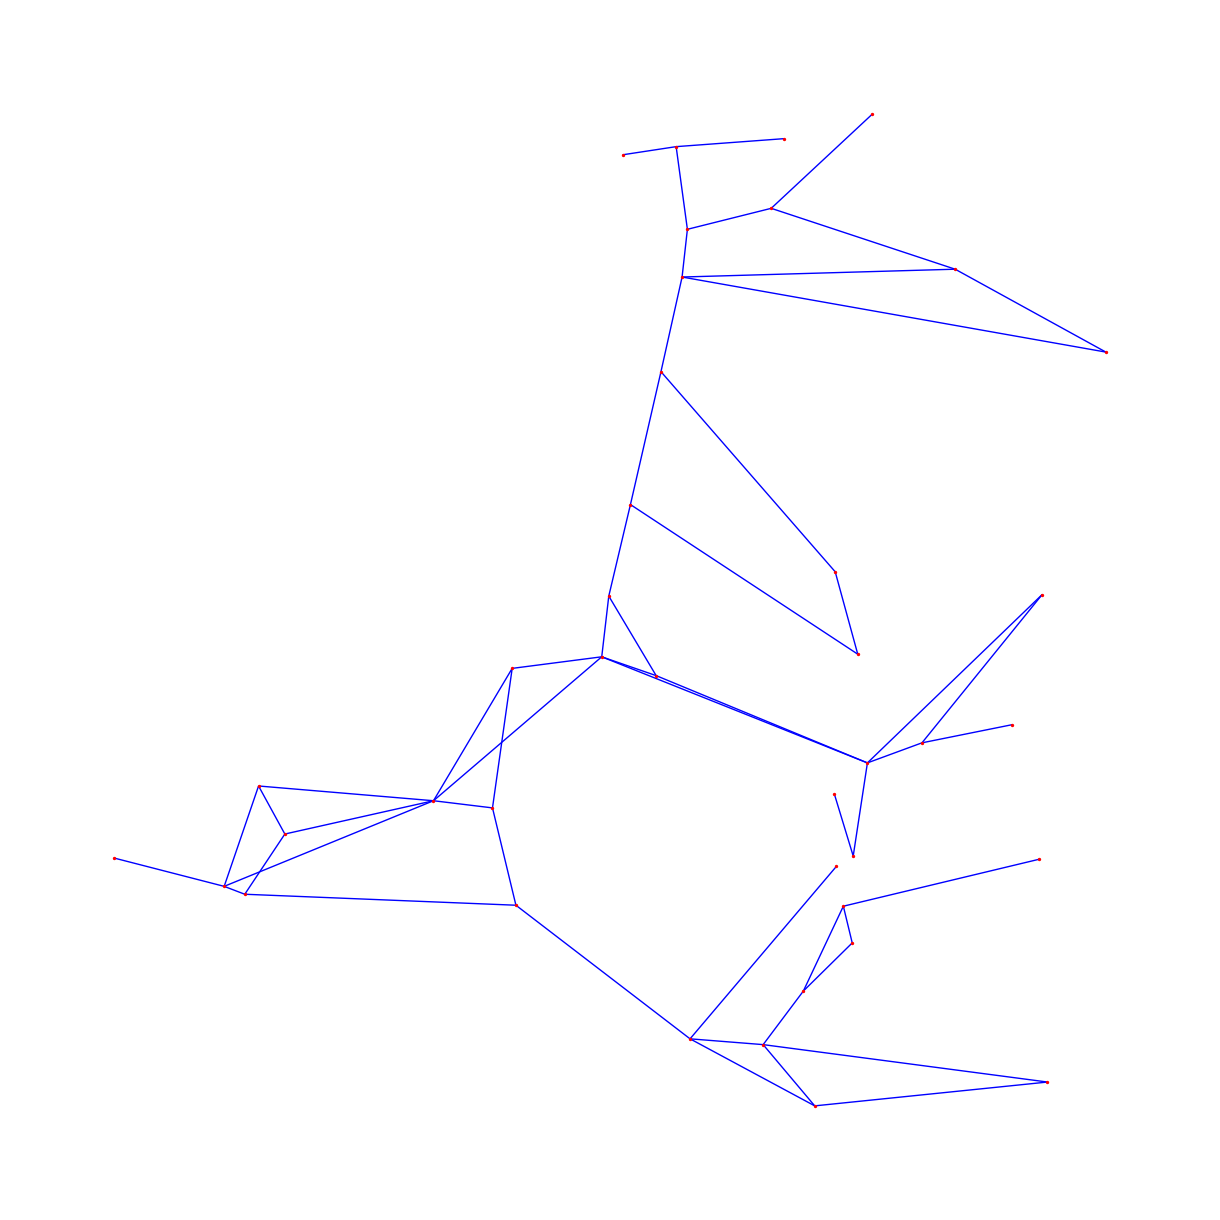

In [589]:
draw_graph(graph)

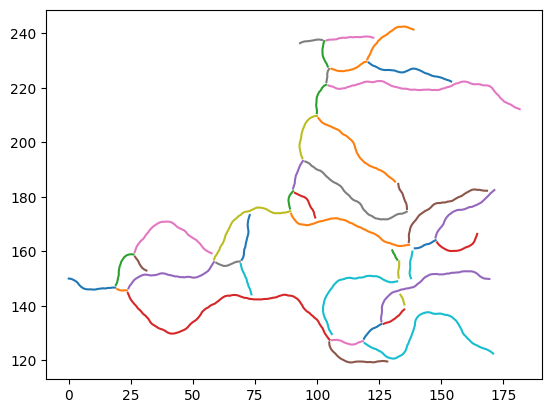

In [590]:
for branchID in sproutDict.keys():
    coord = sproutDict[branchID]
    plt.plot(coord[:,0],coord[:,1])

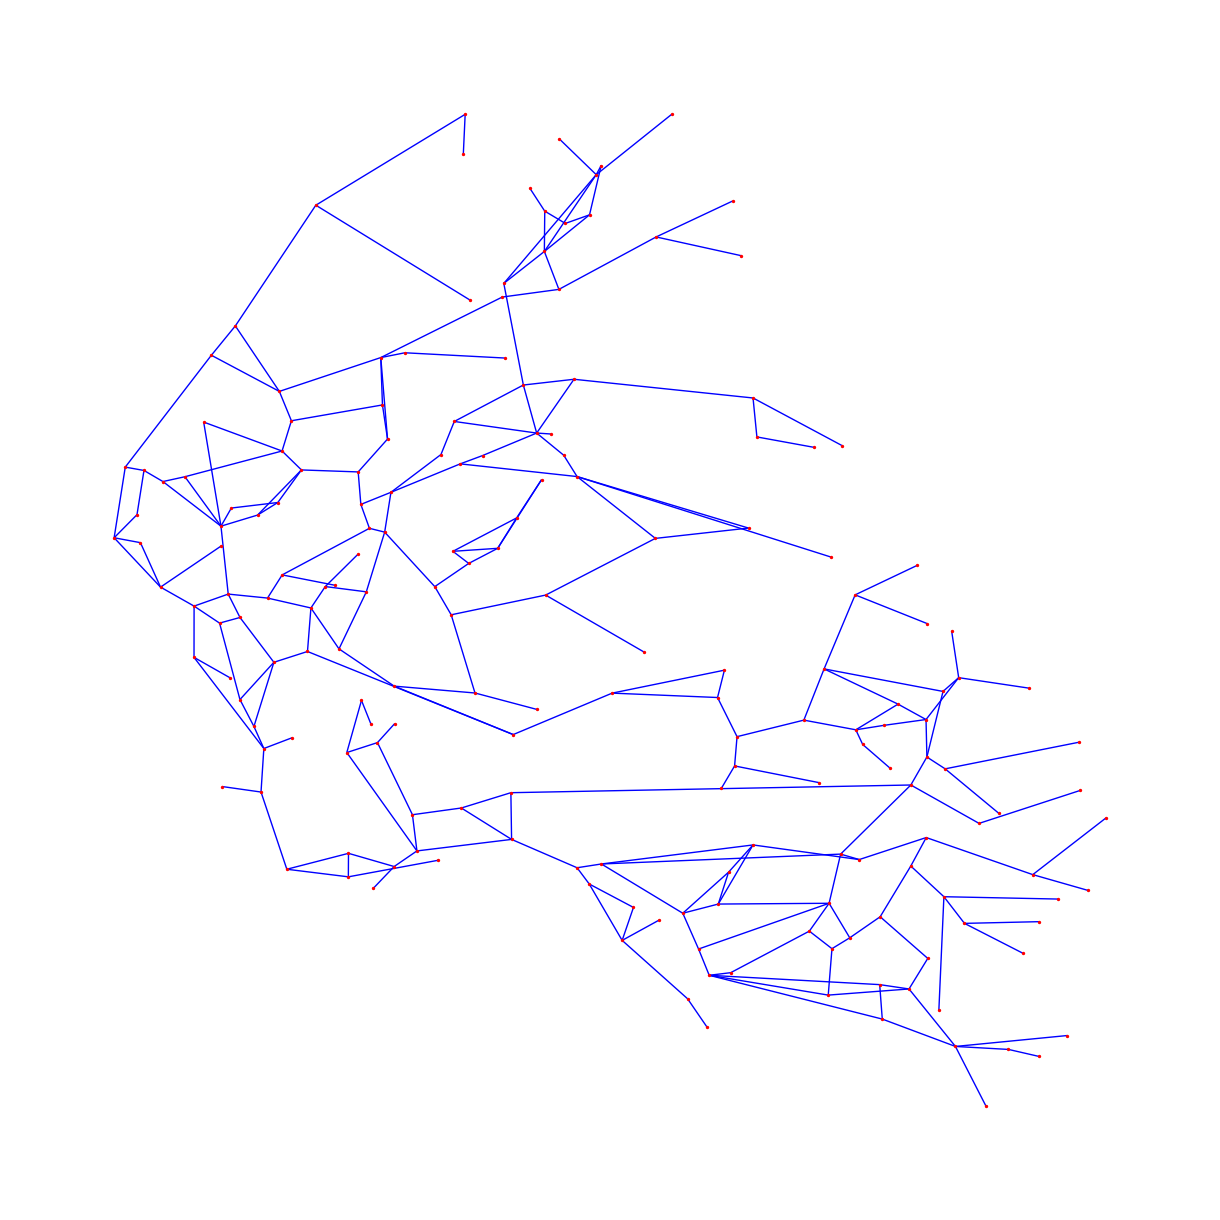

In [426]:
draw_graph(graph)

## KDTree
This is an example to understand how does the KDTree works

In [265]:
import numpy as np
from scipy.spatial import KDTree

# Generate some random 2D points
points = np.random.rand(10, 2)  # 10 random points in 2D space

# Create a KDTree from the points
tree = KDTree(points)


query_point = np.array([0.5, 0.5])


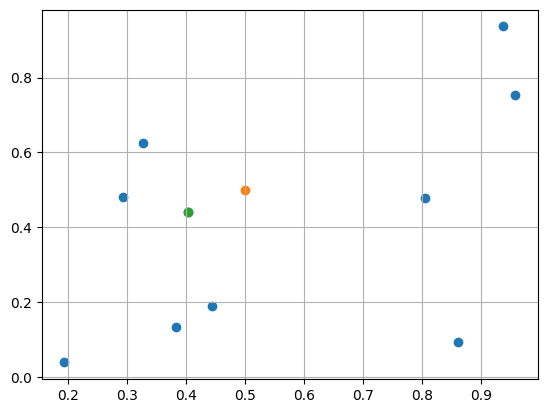

In [275]:
plt.scatter(points[:,0],points[:,1])
plt.scatter(query_point[0], query_point[1])
plt.scatter(points[9,0],points[9,1])
plt.grid()

In [280]:
# Example query: Find the nearest neighbor of a point
distance, index = tree.query(query_point,k=2)

In [283]:
# Example range search: Find all points within a distance of 0.3 from the query point
radius = 0.3
points_within_radius = tree.query_ball_point(query_point, radius)
points_within_radius


[4, 6, 9]

In [282]:
# Output results
print("Points in the dataset:\n", points)
print("\nQuery point:", query_point)
print("\nNearest neighbor:", points[index])
print("Distance to nearest neighbor:", distance)
print("\nPoints within radius of 0.3:", points[points_within_radius])

Points in the dataset:
 [[0.80420574 0.47882624]
 [0.86004246 0.09330867]
 [0.95733794 0.75259582]
 [0.38268712 0.13269848]
 [0.32650575 0.62545055]
 [0.19333349 0.03890457]
 [0.2934645  0.48213039]
 [0.44379563 0.18848371]
 [0.93716592 0.93636388]
 [0.40217479 0.44058421]]

Query point: [0.5 0.5]

Nearest neighbor: [[0.40217479 0.44058421]
 [0.2934645  0.48213039]]
Distance to nearest neighbor: [0.11445527 0.20730711]

Points within radius of 0.3: [[0.32650575 0.62545055]
 [0.2934645  0.48213039]
 [0.40217479 0.44058421]]
